In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

pd.options.display.float_format = lambda x: f"{x:.9f}"

df = pd.read_csv("dataset.csv", low_memory=False)
df = df[["moid", "H", "a", "e", "i", "pha"]].dropna()
df["pha"] = df["pha"].map({"N": 0, "Y": 1}).astype(int)

# add three features 
df["h_moid"] = np.maximum(0.05 - df["moid"], 0.0)
df["h_H"]    = np.maximum(22.0  - df["H"],   0.0)
df["h_AND"]  = df["h_moid"] * df["h_H"]

# 8 columns
X = df[["moid", "H", "a", "e", "i", "h_moid", "h_H", "h_AND"]].values
y = df["pha"].values

# train/test split
X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Use class weights.
X_train = X_train_raw
y_train = y_train_raw
pos = (y_train == 1).sum(); neg = (y_train == 0).sum()
w_pos = len(y_train) / (2 * max(pos, 1))
w_neg = len(y_train) / (2 * max(neg, 1))
sample_weights = np.where(y_train == 1, w_pos, w_neg).astype(float)
sample_weights *= (len(sample_weights) / sample_weights.sum())

# scale
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        self.mean_  = X.mean(axis=0)
        self.scale_ = X.std(axis=0, ddof=0)     
        self.scale_[self.scale_ == 0.0] = 1.0 
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def inverse_transform(self, Z):
        Z = np.asarray(Z, dtype=float)
        return Z * self.scale_ + self.mean_

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test_raw)

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

# support weights + L2 for saturation
def train_logistic_regression(X, y, lr=0.1, epochs=1000, sample_weights=None, l2=3e-2):
    m, n = X.shape
    sw = np.ones(m, dtype=float) if sample_weights is None else sample_weights.astype(float)
    sw *= (m / sw.sum())

    w = np.zeros(n); b = 0.0
    for ep in range(epochs):
        p = sigmoid(X @ w + b)
        wr = sw * (p - y); den = sw.sum()
        dw = (1.0/den) * (X.T @ wr) + (l2/den) * w   # L2 term
        db = (1.0/den) * np.sum(wr)
        w -= lr * dw; b -= lr * db
        if ep % 200 == 0:
            eps = 1e-9
            loss = -(1.0/den) * np.sum(sw * (y*np.log(p+eps) + (1-y)*np.log(1-p+eps))) \
                   + (l2/(2.0*den)) * np.sum(w*w)
            print(f"Epoch {ep}, Loss: {loss:.4f}")
    return w, b

weights, bias = train_logistic_regression(X_train, y_train, sample_weights=sample_weights, l2=3e-2)

# probabilities
y_pred_train = sigmoid(X_train @ weights + bias)
y_pred_test  = sigmoid(X_test  @ weights + bias)


print(f"\nTrain prevalence: {y_train.mean():.4%} | Test prevalence: {y_test.mean():.4%}")
print("Test prob quantiles:", np.quantile(y_pred_test, [0, .25, .5, .75, .9, .99, .999, 1]))

#K factor (threshold)
est_pos_in_test = max(1, int(round(len(y_test) * y_train_raw.mean())))
K_FACTOR = 1.10
K = max(1, min(int(round(K_FACTOR * est_pos_in_test)), len(y_pred_test)))

order  = np.argsort(-y_pred_test)
t_topk = y_pred_test[order[K-1]]
print(f"\nUsing Top-K classification: K={K}, threshold={t_topk:.6f}")

y_pred_train_class = (y_pred_train >= t_topk).astype(int)
y_pred_test_class  = (y_pred_test  >= t_topk).astype(int)

# metrics
train_accuracy = np.mean(y_pred_train_class == y_train)
test_accuracy  = np.mean(y_pred_test_class  == y_test)
precision = precision_score(y_test, y_pred_test_class, zero_division=0)
recall    = recall_score(y_test, y_pred_test_class,  zero_division=0)
f1        = f1_score(y_test, y_pred_test_class,      zero_division=0)
roc_auc   = roc_auc_score(y_test, y_pred_test)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")

# full dataset
X_full = scaler.transform(df[["moid","H","a","e","i","h_moid","h_H","h_AND"]].values)
df["hazard_prob"] = sigmoid(X_full @ weights + bias)


df["hazard_prob_display"] = np.clip(df["hazard_prob"], 1e-9, 0.9999)

df_ranked = df.sort_values("hazard_prob", ascending=False).reset_index(drop=True)
df_ranked["danger_rank"] = np.arange(1, len(df_ranked) + 1)

df["pred_hazard"] = (df["hazard_prob"] >= t_topk).astype(int)


cols = ["danger_rank","hazard_prob_display","pha","moid","H","a","e","i"]

print("\n-- Top 10 --")
print(df_ranked.head(10)[cols].to_string(index=False))

print("\n-- Middle 10 --")
n = len(df_ranked); k = 10
start = max(0, n//2 - k//2)
print(df_ranked.iloc[start:start+k][cols].to_string(index=False))

print("\n-- Bottom 10 (least hazardous) --")
print(df_ranked.tail(10)[cols].to_string(index=False))

/var/folders/6_/30m8fb2x2h59fv4wj90kx9lr0000gp/T/ipykernel_42258/3455445542.py:9: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")


Epoch 0, Loss: 0.6931
Epoch 200, Loss: 0.0985
Epoch 400, Loss: 0.0683
Epoch 600, Loss: 0.0563
Epoch 800, Loss: 0.0496

Train prevalence: 0.2216% | Test prevalence: 0.2215%
Test prob quantiles: [4.32497566e-06 1.29322554e-02 2.26609126e-02 4.06478666e-02
 7.04298782e-02 7.26387098e-01 9.99999999e-01 1.00000000e+00]

Using Top-K classification: K=454, threshold=0.956052
Precision: 0.7819
Recall:    0.8596
F1 Score:  0.8189
ROC-AUC:   0.9991
Train Accuracy: 0.9992
Test Accuracy:  0.9992

-- Top 10 --
 danger_rank  hazard_prob_display  pha        moid            H           a           e            i
           1          0.999900000    1 0.000940799 20.300000000 2.426448624 0.593816665  5.152837151
           2          0.999900000    1 0.029314100 17.700000000 1.903145908 0.552229760  8.269457433
           3          0.999900000    1 0.008369900 18.900000000 0.850765129 0.259118140 26.371486120
           4          0.999900000    1 0.004105030 20.200000000 2.620065785 0.643232564  3.69

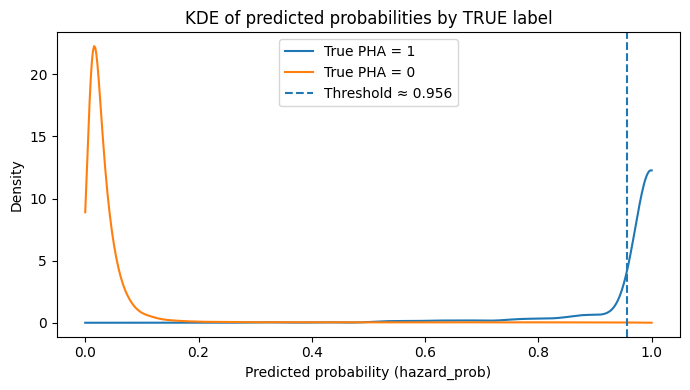

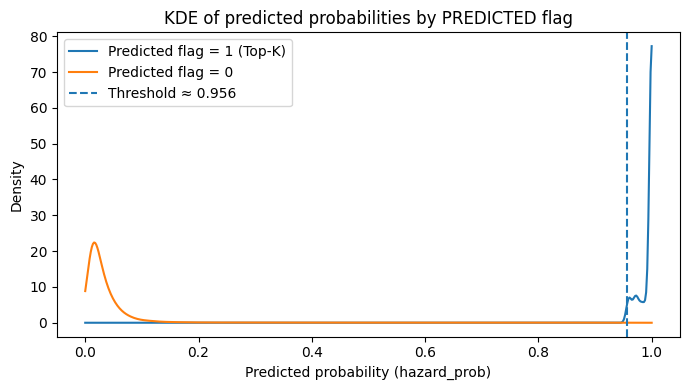


Fraction of samples by probability band (rows = true label):
Bands:  [(0.0, 0.1), (0.1, 0.2), (0.2, 0.5), (0.5, 0.7), (0.7, 0.9), (0.9, 1.0)]
True 1: [0.    0.    0.005 0.034 0.073 0.62 ]
True 0: [0.943 0.027 0.014 0.007 0.006 0.002]

At Top-K threshold ~0.9561: TP=355, FP=99, FN=58, TN=185957
Precision=0.782  Recall=0.860


In [9]:
import numpy as np
import matplotlib.pyplot as plt


def kde_curve(x, grid=None, bandwidth=None):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if grid is None:
        grid = np.linspace(0.0, 1.0, 512)
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(x, bw_method=bandwidth)
        y = kde(grid)
    except Exception:
        #smoothed histogram as a "KDE-ish" curve
        hist, edges = np.histogram(x, bins=50, range=(0,1), density=True)
        centers = 0.5*(edges[:-1] + edges[1:])
        
        w = 3
        hist_smooth = np.convolve(hist, np.ones(w)/w, mode='same')
        #interpolate
        y = np.interp(grid, centers, hist_smooth)
    return grid, y

# split predicted probabilities by TRUE label
p1 = y_pred_test[y_test == 1]   # positive scores
p0 = y_pred_test[y_test == 0]   # negative scores

#Plot: KDE by true label 
grid = np.linspace(0, 1, 512)
g1, d1 = kde_curve(p1, grid)
g0, d0 = kde_curve(p0, grid)

plt.figure(figsize=(7,4))
plt.plot(g1, d1, label='True PHA = 1')
plt.plot(g0, d0, label='True PHA = 0')
#Dotted line for the Top-K threshold
try:
    _ = t_topk
    plt.axvline(t_topk, linestyle='--', label=f'Threshold ≈ {t_topk:.3f}')
except NameError:
    pass
plt.xlabel('Predicted probability (hazard_prob)')
plt.ylabel('Density')
plt.title('KDE of predicted probabilities by TRUE label')
plt.legend()
plt.tight_layout()
plt.show()

# Plot: KDE by predicted flag

p_flag1 = y_pred_test[y_pred_test_class == 1]
p_flag0 = y_pred_test[y_pred_test_class == 0]

gf1, df1 = kde_curve(p_flag1, grid)
gf0, df0 = kde_curve(p_flag0, grid)

plt.figure(figsize=(7,4))
plt.plot(gf1, df1, label='Predicted flag = 1 (Top-K)')
plt.plot(gf0, df0, label='Predicted flag = 0')
try:
    _ = t_topk
    plt.axvline(t_topk, linestyle='--', label=f'Threshold ≈ {t_topk:.3f}')
except NameError:
    pass
plt.xlabel('Predicted probability (hazard_prob)')
plt.ylabel('Density')
plt.title('KDE of predicted probabilities by PREDICTED flag')
plt.legend()
plt.tight_layout()
plt.show()


#key probability bands
bands = [(0.0,0.1),(0.1,0.2),(0.2,0.5),(0.5,0.7),(0.7,0.9),(0.9,1.0)]
def band_counts(p):
    counts = []
    n = len(p)
    for lo, hi in bands:
        counts.append(((p>=lo) & (p<hi)).sum())
    return np.array(counts), n

c1, n1 = band_counts(p1)
c0, n0 = band_counts(p0)
print("\nFraction of samples by probability band (rows = true label):")
print("Bands: ", bands)
print("True 1:", (c1 / max(n1,1)).round(3))
print("True 0:", (c0 / max(n0,1)).round(3))

#Counts inside/outside the Top-K region ()
try:
    _ = t_topk
    tp = np.sum((y_test==1) & (y_pred_test >= t_topk))
    fn = np.sum((y_test==1) & (y_pred_test <  t_topk))
    fp = np.sum((y_test==0) & (y_pred_test >= t_topk))
    tn = np.sum((y_test==0) & (y_pred_test <  t_topk))
    print(f"\nAt Top-K threshold ~{t_topk:.4f}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
    
    prec = tp / max(tp+fp,1); rec = tp / max(tp+fn,1)
    print(f"Precision={prec:.3f}  Recall={rec:.3f}")
except NameError:
    pass